In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os 
import time
from datetime import timedelta

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from PIL import Image
import shutil

import pandas as pd

In [3]:
tran_filenames = os.listdir('data/train')
datasetdir = os.path.join('./data')
traindir = os.path.join(datasetdir,'train2')
testdir = os.path.join(datasetdir,'test2')

batch_size = 32
epochs = 10
csv_name = "submission.csv"
trick = False

In [4]:
train_cat = filter(lambda x:x[:3]=='cat', tran_filenames)
train_dog = filter(lambda x:x[:3]=='dog', tran_filenames)

In [5]:
# from shutil import copyfile

# def rmrf_mkdir(dirname):
#     if os.path.exists(dirname):
#         shutil.rmtree(dirname)
#     os.mkdir(dirname)

# rmrf_mkdir('data/train2')
# os.mkdir('data/train2/cat')
# os.mkdir('data/train2/dog')

# # rmrf_mkdir('test2')
# # os.symlink('../test/', 'test2/test')

# for filename in train_cat:
#     copyfile('data/train/'+filename, 'data/train2/cat/'+filename)

# for filename in train_dog:
#     copyfile('data/train/'+filename, 'data/train2/dog/'+filename)


## 准备数据集

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
train_dataset = datasets.ImageFolder(traindir,transforms.Compose([
    transforms.RandomResizedCrop(224),  #224
    transforms.RandomHorizontalFlip(),  # 随机挑一些图镜像翻转
    transforms.ToTensor(),
    normalize,
]))

n_train = int(len(train_dataset)*0.9)
n_validation = len(train_dataset)-n_train

In [7]:
# 制作训练集验证集
train_data, valid_data = torch.utils.data.random_split(train_dataset, [n_train, n_validation])

In [8]:
print(len(train_data), len(valid_data))

22500 2500


In [9]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10
)

val_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10
)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),   #224
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size = batch_size, shuffle=False,
    num_workers = 10)

In [10]:
classes = [d for d in os.listdir(traindir) if os.path.isdir(os.path.join(traindir, d))]

In [11]:
classes

['cat', 'dog']

In [12]:
test_images = [os.path.join(testdir, 'test', f) for f in sorted(os.listdir(os.path.join(testdir,'test')))]

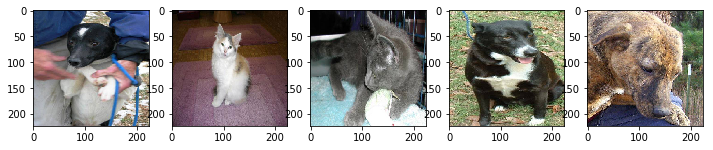

In [13]:
f = plt.figure(figsize=(12,6))
for i, x in enumerate(test_images[:5]):
    f.add_subplot(1, 5, i + 1)
    plt.imshow(Image.open(x).resize((224,224)))

##  加载模型
- 在做比赛的时候，建议使用已经训练好的ImageNet模型进行修改和Fine-Tune，这样可以比较快的提交结果，但是并不说明效果一定比重新训练的好

In [14]:
def check_accu(model, loader):
    num_correct = 0   # 正确的样本数
    num_samples = 0   # 总的样本数
    model.eval() 
    start_time = time.time()
    for x, y in loader:
        with torch.no_grad():
            x_var = x.cuda()
            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('duration = %s' % timedelta(seconds=time.time() - start_time))

def train(model, loader, epochs):
    # start_time=time.time()
    for epoch in range(epochs):
        print("Epoch {}:".format(epoch))
        model.train()
        # t->iteration, x->image, y->label
        for t, (x, y) in enumerate(loader):
            batch_start = time.time()
            x = x.to(device)
            y = y.to(device)
            score = model(x)
            l = loss(score, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (t+1) % 100 == 0:
                info = 't = %d, loss = %.4f, duration = %s'
                print( info % (t + 1, l.item(), timedelta(seconds=time.time() - batch_start)))
                check_accu(model, val_loader)

def run_test(model, loader):#用来对test数据集进行predict的函数
    preds = []
    model.eval()
    start_time = time.time()
    for x, _ in loader:
        with torch.no_grad():
            x_var = x.cuda()
            scores = model(x_var)
            preds.append(scores)
    print('duration = %s\n' % timedelta(seconds=time.time() - start_time))
    return preds

def save_csv(preds, images, csv_name, clib=False):
    pred_soft = F.softmax(torch.cat(preds), dim=1).cpu().numpy()
    if clib:
        pred_soft = pred_soft.clip(min=0.005,max=0.995)
    pred_result = pred_soft[:, 1]
    results = zip(images, pred_result)
    idx = [(x[0].split('/')[-1]).split('.')[0] for x in results]
    #labels = [0 if x[1]<0.5 else 1 for x in results]
    res = pd.DataFrame.from_dict({
        'id': idx,
        'label': pred_result.tolist()
    })
    res = res.set_index('id')
    res.to_csv(csv_name)
    print("Save {} done.".format(csv_name))

In [15]:
def resnet34(pretrained=True):
    # 训练fc层，锁住其他层数
    model = models.resnet34(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False
    for layer in model.children():
        layer.apply(set_untrainable)
    model.fc = nn.Linear(512,2)
    return model

def resnet152(pretrained=True):
    # 训练fc层，锁住其他层数
    model = models.resnet152(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False
    for layer in model.children():
        layer.apply(set_untrainable)
    model.fc = nn.Linear(2048,2)
    return model

def densenet161(pretrained=True):
    model = models.densenet161(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    for layer in model.children():
        layer.apply(set_untrainable)
    model.classifier = nn.Linear(2208, 2)
    return model

def Inceptionv3(pretrained=True, num_classes=2):
    model = models.inception_v3(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    for layer in model.children():
        layer.apply(set_untrainable)
    num_ftrs = model.AuxLogits.fc.in_features
    print(num_ftrs)
    model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    model.fc = nn.Linear(2048, num_classes)
    return model

def check_accu_v3(model, loader):
    num_correct = 0   # 正确的样本数
    num_samples = 0   # 总的样本数
    model.eval() 
    start_time = time.time()
    for x, y in loader:
        with torch.no_grad():
            x_var = x.cuda()
            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('duration = %s' % timedelta(seconds=time.time() - start_time))

def train_v3(model, loader, epochs):
    # start_time=time.time()
    for epoch in range(epochs):
        print("Epoch {}:".format(epoch))
        # t->iteration, x->image, y->label
        for t, (x, y) in enumerate(loader):
            model.train()     # 放在这里很重要 训练时切回来
            batch_start = time.time()
            x = x.to(device)
            y = y.to(device)
            score, score_aux = model(x)
            l1 = loss(score, y)
            l2 = loss(score_aux, y)
            l = l1 + 0.4*l2
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (t+1) % 100 == 0:
                info = 't = %d, loss = %.4f, duration = %s'
                print( info % (t + 1, l.item(), timedelta(seconds=time.time() - batch_start)))
                check_accu_v3(model, val_loader)

def run_test_v3(model, loader):#用来对test数据集进行predict的函数
    preds = []
    model.eval()
    start_time = time.time()
    for x, _ in loader:
        with torch.no_grad():
            x_var = x.cuda()
            scores = model(x_var)
            preds.append(scores)
    print('duration = %s\n' % timedelta(seconds=time.time() - start_time))
    return preds

## 训练

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet34()
# model = densenet161()
# model = densenet201()
# model = resnet152()
# model = Inceptionv3()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

print("Model:", model.named_parameters)

loss = nn.CrossEntropyLoss().cuda()
# 只把需要adam的参数
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-2)

Model: <bound method Module.named_parameters of DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1

In [16]:
train(model, train_loader, epochs=epochs)

Epoch 0:
t = 100, loss = 0.3120, duration = 0:00:00.392764
Got 2408 / 2500 correct (96.32)
duration = 0:00:24.576346
t = 200, loss = 0.2563, duration = 0:00:00.384568
Got 2386 / 2500 correct (95.44)
duration = 0:00:24.716081
t = 300, loss = 0.0311, duration = 0:00:00.385444
Got 2378 / 2500 correct (95.12)
duration = 0:00:24.484531
t = 400, loss = 0.2956, duration = 0:00:00.445291
Got 2380 / 2500 correct (95.20)
duration = 0:00:24.317295
t = 500, loss = 0.0264, duration = 0:00:00.345362
Got 2413 / 2500 correct (96.52)
duration = 0:00:24.353093
t = 600, loss = 0.1922, duration = 0:00:00.385013
Got 2359 / 2500 correct (94.36)
duration = 0:00:24.913270
t = 700, loss = 0.0045, duration = 0:00:00.373286
Got 2408 / 2500 correct (96.32)
duration = 0:00:24.196078
Epoch 1:
t = 100, loss = 0.8213, duration = 0:00:00.365561
Got 2394 / 2500 correct (95.76)
duration = 0:00:24.961631
t = 200, loss = 0.2036, duration = 0:00:00.393526
Got 2405 / 2500 correct (96.20)
duration = 0:00:24.273633
t = 300, l

## 测试

In [17]:
preds = run_test(model, test_loader)
save_csv(preds, test_images, csv_name, clib=trick)

duration = 0:01:51.661695

Save submission.csv done.


In [18]:
save_csv(preds, test_images, csv_name, clib=True)

Save submission.csv done.


In [27]:
# 什么是finetune,怎么finetune?
# 提交gz文件
# 加和 average/max 
# 多个网络提feature，然后再加两层或一层全连接

## trick

In [31]:
# pred_soft.clip(min=0.005,max=0.995)

array([[0.005     , 0.995     ],
       [0.995     , 0.005     ],
       [0.995     , 0.005     ],
       ...,
       [0.005     , 0.995     ],
       [0.005     , 0.995     ],
       [0.02073302, 0.979267  ]], dtype=float32)

作业：
请大家使用 densenet/resnet/shufflenet/googlenet等网络进行finetune

建议使用imagenet已经训练好的模型进行finetune

并提交排名

可进行如下方法的探索：

1) 单模型的finetune

2) 多模型的average/max,进行合并提交

3) 所有的已经训练好的imagenet模型使用倒数第二层的多个模型的feature，合并后进行上层训练(stacking)


In [45]:
resnet34_sub_data = pd.read_csv("submission-resnet34-e10b32-trick.csv")

In [53]:
import numpy as np
np_list = np.array(resnet34_sub_data.label.tolist())

In [56]:
resnet34_label = np_list.clip(min=0.005,max=0.995)

In [60]:
res = pd.DataFrame.from_dict({
        'id': resnet34_sub_data.id.tolist(),
        'label': resnet34_label.tolist()
    })
res = res.set_index('id')
res.to_csv(csv_name)
print("Save {} done.".format(csv_name))

Save submission.csv done.


## Train inception_v3

In [42]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
train_dataset = datasets.ImageFolder(traindir,transforms.Compose([
    transforms.RandomResizedCrop(299),  #224
    transforms.RandomHorizontalFlip(),  # 随机挑一些图镜像翻转
    transforms.ToTensor(),
    normalize,
]))

n_train = int(len(train_dataset)*0.9)
n_validation = len(train_dataset)-n_train

train_data, valid_data = torch.utils.data.random_split(train_dataset, [n_train, n_validation])

print(len(train_data), len(valid_data))

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10,
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=10,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transforms.Compose([
        transforms.Resize(331),
        transforms.CenterCrop(299),   #224
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size = batch_size, 
    shuffle=False,
    num_workers = 10,)

22500 2500


In [41]:
train_v3(model, train_loader, epochs=epochs)

Epoch 0:
t = 100, loss = 0.6598, duration = 0:00:00.226578
Got 2316 / 2496 correct (92.79)
duration = 0:00:15.880223
t = 200, loss = 0.8107, duration = 0:00:00.225780
Got 2346 / 2496 correct (93.99)
duration = 0:00:16.001577
t = 300, loss = 2.0935, duration = 0:00:00.242332
Got 2347 / 2496 correct (94.03)
duration = 0:00:16.056284
t = 400, loss = 1.8428, duration = 0:00:00.230788
Got 2364 / 2496 correct (94.71)
duration = 0:00:16.102827
t = 500, loss = 0.6756, duration = 0:00:00.206538
Got 2225 / 2496 correct (89.14)
duration = 0:00:15.788206
t = 600, loss = 0.2444, duration = 0:00:00.222937
Got 2374 / 2496 correct (95.11)
duration = 0:00:15.758815
t = 700, loss = 0.7727, duration = 0:00:00.199639
Got 2356 / 2496 correct (94.39)
duration = 0:00:15.884024
Epoch 1:
t = 100, loss = 1.6835, duration = 0:00:00.200095
Got 2396 / 2496 correct (95.99)
duration = 0:00:15.835849
t = 200, loss = 0.7868, duration = 0:00:00.217336
Got 2336 / 2496 correct (93.59)
duration = 0:00:15.959505
t = 300, l

In [45]:
preds = run_test_v3(model, test_loader)
save_csv(preds, test_images, csv_name, clib=trick)

duration = 0:01:09.209091

Save submission.csv done.


In [38]:
?torch.utils.data.DataLoader

In [46]:
save_csv(preds, test_images, csv_name, clib=True)

Save submission.csv done.


## Average

In [50]:
csv_files = []
for csv in os.listdir("./csv"):
    if "trick" not in csv:
        csv_files.append(csv)
print(csv_files)

['submission-densenet161-e10b32.csv', 'submission-inceptionv3-e10b32.csv', 'submission-resnet154-e10b32.csv', 'submission-resnet34-e10b32.csv']


In [90]:
from itertools import combinations
import numpy as np

model2frame_dic = {}
model_list = []
for f in csv_files:
    model_name = f.split("-")[1]
    model_list.append(model_name)
    fpath = "./csv/" + f
    data = pd.read_csv(fpath)
    model2frame_dic[model_name] = data

comb_names = list(combinations(model_list, 3))

for m1, m2, m3 in comb_names:
    sub_name = "submission-{}-{}-{}.csv".format(m1,m2,m3)
    idx = model2frame_dic[m1].id.tolist()
    labels = ((model2frame_dic[m1].label + model2frame_dic[m2].label+model2frame_dic[m3].label)/3).tolist()
    res = pd.DataFrame.from_dict({
        'id': idx,
        'label': labels
    })
    res = res.set_index('id')
    res.to_csv(sub_name)
    
    sub_trick_name = "submission-{}-{}-{}-trick.csv".format(m1,m2,m3)
    clip_labels = (np.array(labels)).clip(min=0.005,max=0.995)
    trick_res = pd.DataFrame.from_dict({
        'id': idx,
        'label': clip_labels
    })
    trick_res = trick_res.set_index('id')
    trick_res.to_csv(sub_trick_name)
print("Done!")   

Done!


In [70]:
def all_model_csv(model_limodel_li):
    model_li = [x for x in model2frame_dic]
    model_name = "-".join(model_li)
    sub_name = "submission-{}.csv".format(model_name)
    idx = model2frame_dic[model_li[0]].id.tolist()
    res  = pd.DataFrame.from_dict({
        'id': idx,
        'label': [0.0 for i in range(len(idx))]
    })
    for k in model_li:
        res.label += model2frame_dic[k].label
    res.label = (res.label / len(model_li))
    res = res.set_index('id')
    res.to_csv(sub_name)
    
    sub_trick_name = "submission-{}-trick.csv".format(model_name)
    clip_labels = (np.array(res.label)).clip(min=0.005,max=0.995)
    trick_res = pd.DataFrame.from_dict({
        'id': idx,
        'label': clip_labels
    })
    trick_res = trick_res.set_index('id')
    trick_res.to_csv(sub_trick_name)
    print("Done!")
all_model_csv(model2frame_dic)

Done!


## featureExtracting

In [18]:
len(train_dataset)

25000